In [119]:
import os
import sys
import json

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import einops

import shared.utils as su

os.environ['TOKENIZERS_PARALLELISM'] = "False"
plt.rcParams["font.family"] = "serif"

### Load data

In [2]:
DATA_ROOT = "/scratch/shared/beegfs/piyush/datasets"
VIDEO_DIR = {
    "ssv2": f"{DATA_ROOT}/SSv2/20bn-something-something-v2",
    "epic": f"{DATA_ROOT}/EPIC-Kitchens-100/cut_clips",
    "charades": f"{DATA_ROOT}/Charades/Charades_v1_480_cut_clips"
}
EXT = {
    'ssv2': 'webm',
    'epic': 'MP4',
    'charades': 'mp4',
}
REPO_PATH = "/users/piyush/projects/TimeBound.v1/"
SPLIT_DIR = f"{REPO_PATH}/adapt4change/chirality_in_action_splits"


def load_data(dataset='ssv2'):
    
    # Pick CSV path
    csv_path = f"{SPLIT_DIR}/cia-{dataset}-validation.csv"
    assert os.path.exists(csv_path)
    df = pd.read_csv(csv_path)

    # Add text ID
    df['text_id'] = df[['chiral_triplet_id', 'chiral_label']].apply(
        lambda x: f"{x[0]}_{x[1]}", axis=1,
    )
    video_dir = VIDEO_DIR[dataset]
    ext = EXT[dataset]

    df['video_path'] = df['id'].apply(lambda x: f"{video_dir}/{x}.{ext}")
    df = df[df.video_path.apply(os.path.exists)]
    print("Number of rows: ", len(df))
    print("Sample row: ")
    print(json.dumps(df.iloc[0].to_dict(), indent=4))
    
    return df

In [3]:
# Load data
df = load_data(dataset='ssv2')

Number of rows:  1430
Sample row: 
{
    "id": 69703,
    "label": "moving pen up",
    "template": "Moving [something] up",
    "placeholders": "['pen']",
    "target": 114,
    "chiral_label": 0.0,
    "chiral_triplet_id": "3f20f09b",
    "noun": "['something']",
    "text_id": "3f20f09b_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/69703.webm"
}


### Load model

In [4]:
def load_model(model_path_or_name='CaRe-7B'):

    su.log.print_update(f"Loading model ({model_path_or_name}).")

    # Load model
    from models.modeling_encoders import AutoEncoder
    encoder = AutoEncoder.from_pretrained(model_path_or_name, device_map='auto', attn_type='flash_attention2')
    su.misc.num_params(encoder.model)

    # Define a feature computer: video_tensor -> video_feature
    class VideoFeatureComputer:
        def __init__(self, encoder):
            self.encoder = encoder
        
        def __call__(self, video_tensor):
            with torch.no_grad():
                vision_emb = encoder.encode_vision(
                    video_tensor.unsqueeze(0),
                ).cpu().squeeze(0).float()
            return vision_emb
    vfc = VideoFeatureComputer(encoder)


    # Define a video processor: video_path -> video_tensor
    from utils.video import read_frames_decord
    class VideoProcessor:
        def __init__(self, n_frames=16):
            self.n_frames = n_frames
        
        def __call__(self, video_path):
            video = read_frames_decord(video_path, self.n_frames)
            return video
    vp = VideoProcessor(n_frames=16)


    # Define a text feature computer: text_str -> text_feature
    class TextFeatureComputer:
        def __init__(self, encoder):
            self.encoder = encoder
        
        def __call__(self, text_str):
            with torch.no_grad():
                text_emb = encoder.encode_text(text_str).cpu().squeeze(0).float()
            return text_emb
    tfc = TextFeatureComputer(encoder)

    return vfc, tfc, vp, encoder


model_path_or_name = "/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k"
vfc, tfc, vp, encoder = load_model(model_path_or_name)

Loading model (/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k).  


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForQwen2VL from /work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [5]:
# Compute video features
video_paths = df.video_path.unique()
video_ids = df.id.unique()
video_feat = {}
j = 0
for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
    video_tensor = vp(video_path)
    zv = vfc(video_tensor)
    zv = torch.nn.functional.normalize(zv, dim=-1)
    video_feat[video_ids[j]] = zv
    j += 1

Computing video features:   0%|          | 0/1430 [00:00<?, ?it/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [9]:
# Visualise tsne
X = torch.stack([video_feat[k] for k in df.id.tolist()])
tsne = su.visualize.reduce_dim(X)
tsne.shape

(1430, 2)

In [11]:
df

,id,label,template,placeholders,target,chiral_label,chiral_triplet_id,noun,text_id,video_path
0,69703,moving pen up,Moving [something] up,['pen'],114,0.0,3f20f09b,['something'],3f20f09b_0.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
1,217571,folding cloth,Folding [something],['cloth'],46,1.0,12055391,['something'],12055391_1.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
2,24837,folding mat,Folding [something],['mat'],46,1.0,12055391,['something'],12055391_1.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
3,96312,unfolding paper,Unfolding [something],['paper'],82,0.0,12055391,['something'],12055391_0.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
4,29910,moving wallet down,Moving [something] down,['wallet'],112,1.0,3f20f09b,['something'],3f20f09b_1.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
...,...,...,...,...,...,...,...,...,...,...
1425,194086,opening a box,Opening [something],['a box'],115,0.0,677ffe97,['object'],677ffe97_0.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
1426,112252,moving charger down,Moving [something] down,['charger'],112,1.0,3f20f09b,['something'],3f20f09b_1.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
1427,86588,taking spoon,Taking [one of many similar things on the table],['spoon'],53,0.0,b58b2f93,['something'],b58b2f93_0.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...
1428,157360,unfolding a shirt,Unfolding [something],['a shirt'],82,0.0,12055391,['something'],12055391_0.0,/scratch/shared/beegfs/piyush/datasets/SSv2/20...


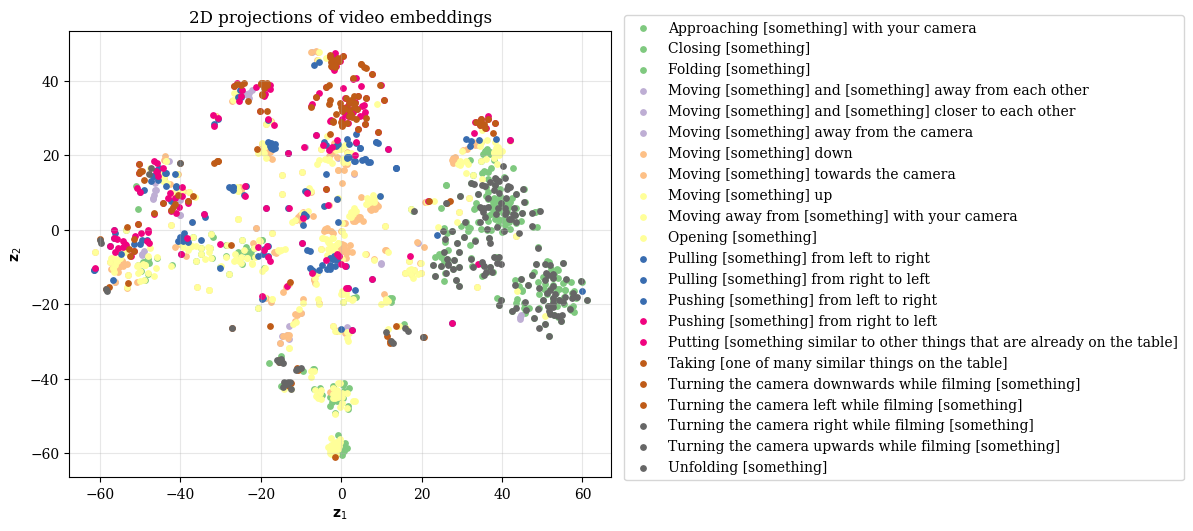

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5.8))
ax.grid(alpha=0.3)

ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.set_title("2D projections of video embeddings")

labels = df['template'].values
unique_labels = np.unique(labels)
cmap = 'Accent'
colors = su.visualize.get_colors(len(unique_labels), palette=cmap)

for j, l in enumerate(unique_labels):
    index = np.where(labels == l)[0]
    z = tsne[index]
    ax.scatter(z[:, 0], z[:, 1], s=15, color=colors[j], label=l)

ax.legend(bbox_to_anchor=(1.01, 1.05))
plt.show()

In [80]:
chiral_triplet_id_to_desc = {
    "3f20f09b": "Moving [something] up/down",
    "a1383a77": "Moving [x] and [y] away from/toward each other",
    "545d0d67": "Moving [something] towards/away from the camera",
    "12055391": "Folding/unfolding [something]",
    "b58b2f93": "Taking/Putting [one of many similar things on the table]",
    "743faf6b": "Pushing [something] from $\\rightarrow$ / $\\leftarrow$",
    "106d2603": "Pulling [something] from $\\rightarrow$ / $\\leftarrow$",
    "ccff0ef2": "Turning the camera right/left ...",
    "677ffe97": "Opening/closing [object]",
    "c1c62263": "Opening/closing [bottle]",
    "1539a698": "Opening/closing [drawer]",
    "81dd0413": "Opening/closing [book]",
    "584d53c4": "Opening/closing [door]",
    "15c7cb08": "Opening/closing [purse]",
    "edebebd4": "Turning the camera upwards/downwards ...",
    "27f40159": "Approaching/moving away from [something] with your camera",
}
len(chiral_triplet_id_to_desc), len(df.chiral_triplet_id.unique())

(16, 16)

In [81]:
from matplotlib.lines import Line2D

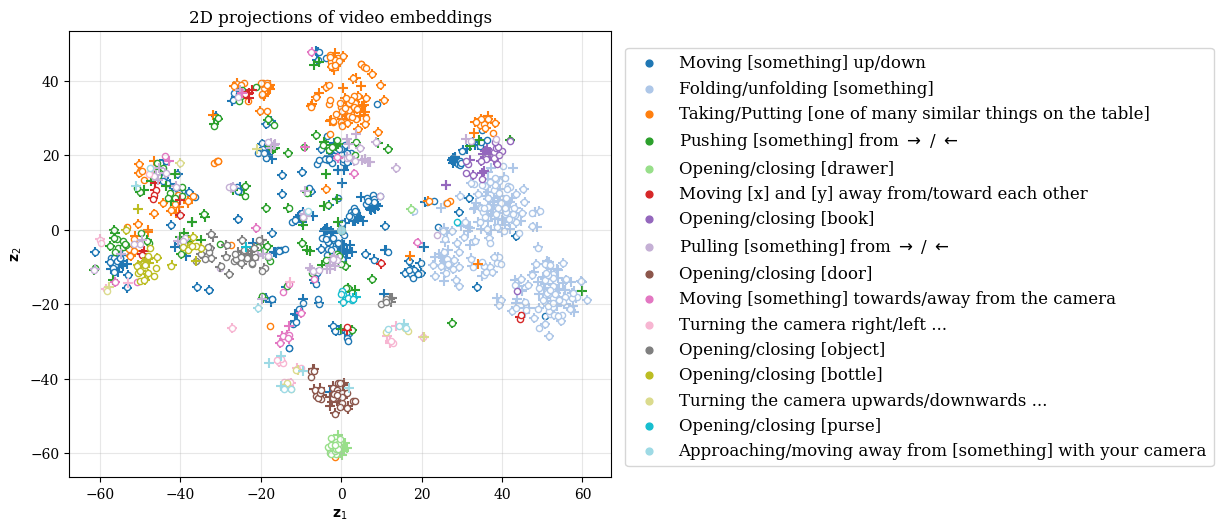

In [85]:
triplet_ids = df.chiral_triplet_id.unique()
# cmap = 'Accent'
cmap = 'tab20'
colors = su.visualize.get_colors(len(triplet_ids), palette=cmap)


fig, ax = plt.subplots(1, 1, figsize=(7, 5.8))
ax.grid(alpha=0.3)

ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.set_title("2D projections of video embeddings")

triplet_handles = []
triplet_labels = []
for i, t in enumerate(triplet_ids):
    # Positives
    index_pos = np.where((df.chiral_triplet_id == t) & (df.chiral_label == 1.))[0]
    # Negatives
    index_neg = np.where((df.chiral_triplet_id == t) & (df.chiral_label == 0.))[0]

    label_pos = df[(df.chiral_triplet_id == t) & (df.chiral_label == 1.)].template.iloc[0]
    label_neg = df[(df.chiral_triplet_id == t) & (df.chiral_label == 0.)].template.iloc[0]

    ax.scatter(tsne[index_pos, 0], tsne[index_pos, 1], color=colors[i], marker='+', s=45)
    ax.scatter(tsne[index_neg, 0], tsne[index_neg, 1], color=colors[i], marker='o', s=20, facecolor='white')
    # ax.scatter([0], [0], color=colors[i], label=chiral_triplet_id_to_desc[t], s=14)
    
    # plot a small colored marker for legend and capture its handle
    h = ax.scatter([0], [0], color=colors[i], label=chiral_triplet_id_to_desc[t], s=24)
    triplet_handles.append(h)
    triplet_labels.append(chiral_triplet_id_to_desc[t])


ax.legend(bbox_to_anchor=(1.01, 0.98), fontsize=12)

plt.show()

#### Test feature sequence from visual encoder

**Make a copy of the visual encoder (without the merger)**

In [112]:
from copy import deepcopy
vision_encoder = deepcopy(encoder.model.visual)
vision_encoder.merger = torch.nn.Identity()
vision_encoder

Qwen2VisionTransformerPretrainedModel(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
  )
  (rotary_pos_emb): VisionRotaryEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x Qwen2VLVisionBlock(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): VisionSdpaAttention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (mlp): VisionMlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): QuickGELUActivation()
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
    )
  )
  (merger): Identity()
)

In [131]:
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)
from torchvision.transforms.functional import InterpolationMode

VIDEO_MIN_PIXELS = 128 * 28 * 28
VIDEO_MAX_PIXELS = 768 * 28 * 28
FRAME_FACTOR = 2
VIDEO_TOTAL_PIXELS = 24576 * 28 * 28
IMAGE_FACTOR = 28

def preprocess_video_tensor(pixel_values):
    nframes, _, height, width = pixel_values.shape
    min_pixels = VIDEO_MIN_PIXELS
    total_pixels = VIDEO_TOTAL_PIXELS
    max_pixels = max(min(VIDEO_MAX_PIXELS, total_pixels / nframes * FRAME_FACTOR), int(min_pixels * 1.05))
    max_pixels = 230400
    resized_height, resized_width = encoder.smart_resize(
        height,
        width,
        factor=IMAGE_FACTOR,
        min_pixels=min_pixels,
        max_pixels=max_pixels,
    )
    pixel_values = functional.resize(
        pixel_values,
        [resized_height, resized_width],
        interpolation=InterpolationMode.BICUBIC,
        antialias=True,
    ).float()
    inputs = encoder.processor(
        text=[''],
        images=None,
        videos=[pixel_values],
        padding=True,
        return_tensors="pt",
    )
    return inputs

In [130]:
# Define a video processor: video_path -> video_tensor
from utils.video import read_frames_decord
class VideoProcessor:
    def __init__(self, n_frames=16):
        self.n_frames = n_frames
    
    def __call__(self, video_path):
        video = read_frames_decord(video_path, self.n_frames)
        return video


i = 0
row = df.iloc[i].to_dict()
video_path = row['video_path']

vp_dense = VideoProcessor(n_frames=32)
video_tensor = vp_dense(video_path)
inputs = preprocess_video_tensor(video_tensor)

video_tensor.shape, inputs['pixel_values_videos'].shape

(torch.Size([32, 3, 240, 320]), torch.Size([8960, 1176]))

In [134]:
x = inputs['pixel_values_videos']
thw = inputs['video_grid_thw']
with torch.no_grad():
    z = vision_encoder(
        x.cuda(), thw,
    )
t, h, w = thw[0].numpy()
x.shape, z.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.79 GiB. GPU 0 has a total capacity of 15.72 GiB of which 3.25 GiB is free. Including non-PyTorch memory, this process has 12.47 GiB memory in use. Of the allocated memory 11.36 GiB is allocated by PyTorch, and 939.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [123]:

z_t = einops.rearrange(z.cpu(), "(t h w) d -> t h w d", t=t, h=h, w=w).mean(dim=(1, 2))
z_t.shape

torch.Size([8, 1280])

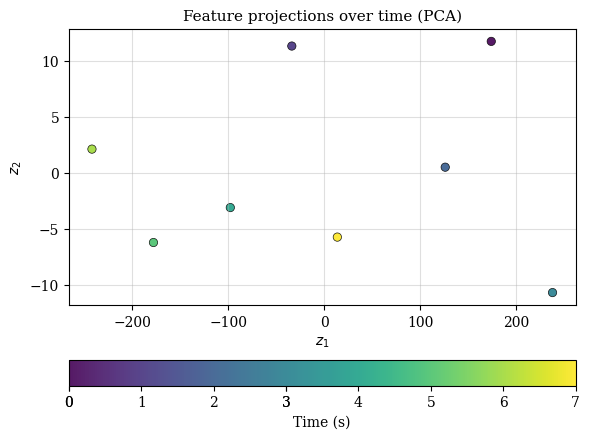

In [128]:
su.visualize.show_temporal_tsne(z_t.float(), tsne_kwargs={'method': 'pca'},)

In [98]:
with torch.no_grad():
    z = encoder.model.visual(video_inputs['pixel_values_videos'].cuda(), video_inputs['video_grid_thw'])
z.shape

torch.Size([1080, 3584])

In [99]:
video_inputs['video_grid_thw']

tensor([[ 8, 18, 30]])

In [103]:
z.shape[0] / 8

135.0

In [100]:
video_inputs['pixel_values_videos'].shape, z.shape

(torch.Size([4320, 1176]), torch.Size([1080, 3584]))

## Video batch processing

I will fix this later. Currently, somehow it does not work.

In [5]:
# Load model
from models.modeling_encoders import AutoEncoder

model_path_or_name = "/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k"
encoder = AutoEncoder.from_pretrained(model_path_or_name, device_map='auto', attn_type='flash_attention2')
su.misc.num_params(encoder.model)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForQwen2VL from /work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [6]:
# Encode videos
from utils.video import read_frames_decord, pad_to_square_then_resize


# Define a video processor: video_path -> video_tensor
class VideoProcessor:
    def __init__(self, n_frames=16, pad_to_square=True, resize_to=448):
        self.n_frames = n_frames
        self.pad_to_square = pad_to_square
        self.resize_to = resize_to
    
    def __call__(self, video_path):
        video = read_frames_decord(video_path, self.n_frames)

        if self.pad_to_square:
            # Resize min side to min_side and then center pad it with zeros
            video = pad_to_square_then_resize(video, resize_to=self.resize_to)

        return video


vp = VideoProcessor(n_frames=16, pad_to_square=True, resize_to=448)


# Define a dataset to process a list of video paths
class VideoDataset(Dataset):
    def __init__(self, video_paths, video_processor):
        super().__init__()
        self.video_paths = video_paths
        self.video_processor = video_processor

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, i):
        video_path = self.video_paths[i]
        video_tensor = self.video_processor(video_path)
        return dict(video_path=video_path, video_tensor=video_tensor)


ds_video = VideoDataset(df.video_path.tolist(), vp)
j = np.random.randint(len(ds_video))
item = ds_video[j]
len(ds_video), item['video_tensor'].shape

(1430, torch.Size([16, 3, 448, 448]))

1430 torch.Size([16, 3, 448, 448])


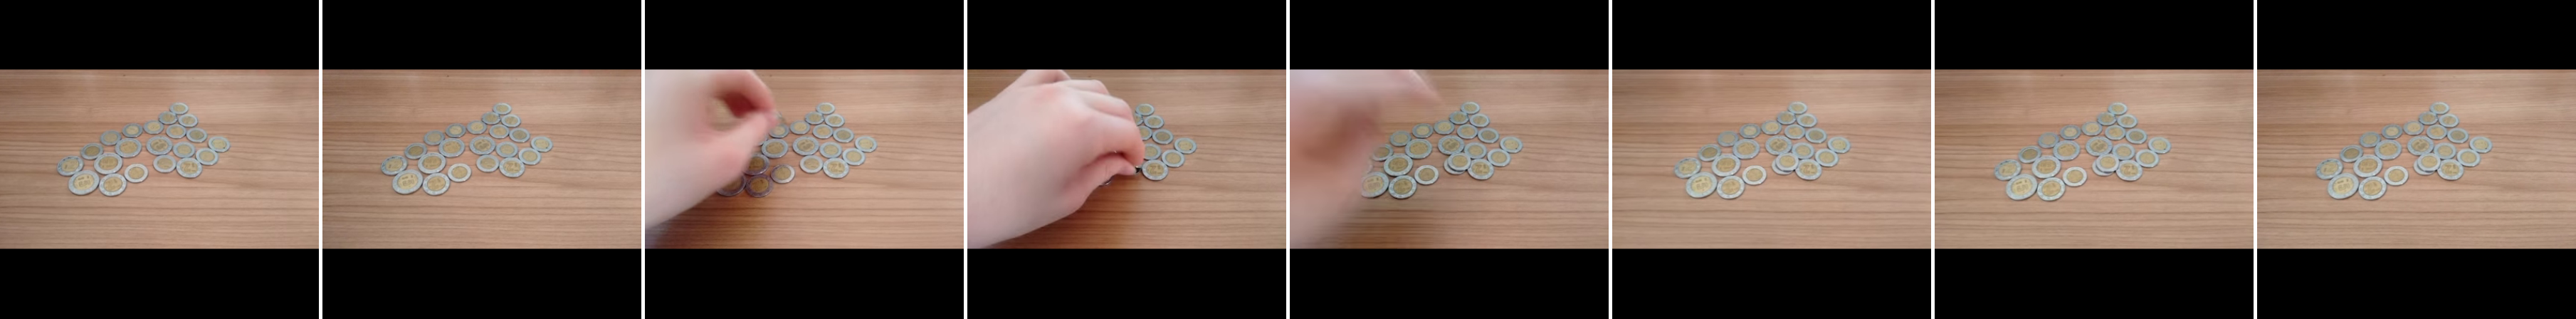

In [7]:
# Verify
j = np.random.randint(len(ds_video))
item = ds_video[j]
print(len(ds_video), item['video_tensor'].shape)


to_pilimg = torchvision.transforms.ToPILImage()
display(
    su.visualize.concat_images_with_border([to_pilimg(x) for x in item['video_tensor']][::2])
)

In [8]:
dl_video = DataLoader(
    ds_video, batch_size=1, num_workers=1, shuffle=False, drop_last=False,
)
len(dl_video)

1430

In [9]:
check_dl = False
if check_dl:
    # Check how long it takes to do a full iterator
    iterator = su.log.tqdm_iterator(dl_video, desc="Processing videos")
    for batch in iterator:
        pass

In [10]:
# Compute video embeddings
iterator = su.log.tqdm_iterator(dl_video, desc="Processing videos")
video_embeds = {}
for batch in iterator:
    video_tensor = batch['video_tensor']
    video_paths = batch['video_path']
    with torch.no_grad():
        vision_emb = encoder.encode_vision(
            video_tensor,
        ).cpu().float()
    for j in range(len(video_paths)):
        video_paths[video_paths[j]] = vision_emb[j]
    del batch
len(video_paths)

Processing videos:   0%|          | 0/1430 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 15.72 GiB of which 2.62 GiB is free. Including non-PyTorch memory, this process has 13.10 GiB memory in use. Of the allocated memory 12.70 GiB is allocated by PyTorch, and 203.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)